In [3]:
from datetime import datetime
from getpass import getpass

rdm_url = 'https://bh.rdm.yzwlab.com/' # 'https://staging.rdm.example.com'
idp_name_1 = None # 'GakuNin RDM IdP'
idp_username_1 = None
idp_password_1 = None
rdm_project_name = 'TEST-METADATA-{}'.format(datetime.now().strftime('%Y%m%d-%H%M%S'))
default_result_path = None
close_on_fail = False
transition_timeout = 10000

In [4]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

In [5]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmpoozwk8tr'

# e-Rad情報を用いた自動補完

- サブシステム名: アドオン
- ページ/アドオン: Metadata
- 機能分類: ユーザー設定
- シナリオ名: e-Rad情報の設定
- 用意するテストデータ: URL一覧、アカウント(既存ユーザー1: GRDM)
- 事前条件: 「プロジェクトに対するMetadataアドオンの登録」を実施済みであり、e-Radダミーデータが登録済みであること

## ウェブブラウザの新規プライベートウィンドウでGRDMトップページを表示する

GRDMトップページが表示されること

In [6]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=False, last_path=default_result_path)

('20250520-002353', '/tmp/tmpc7ffwxby')

Start epoch: 1747700633.7198143 seconds


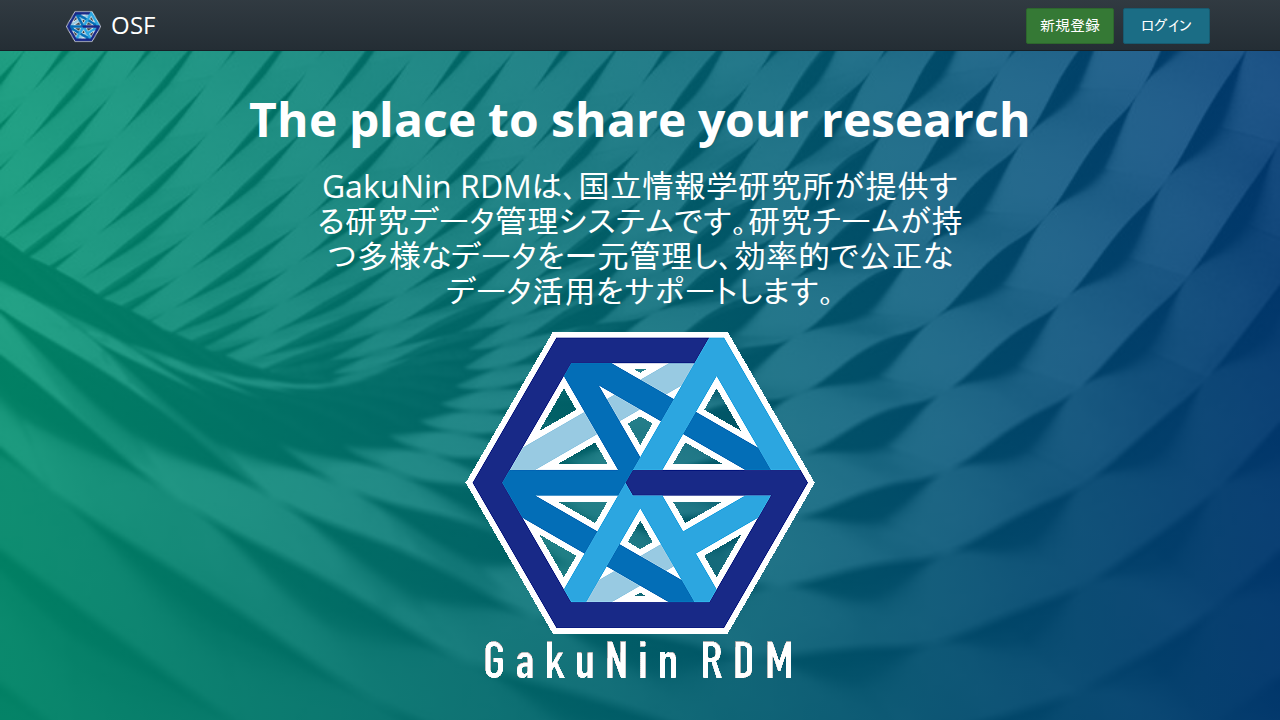

In [7]:
import time

async def _step(page):
    await page.goto(rdm_url)

    # 同意する をクリック
    await page.locator('//button[text() = "同意する"]').click()

    # 同意する が表示されなくなったことを確認
    await expect(page.locator('//button[text() = "同意する"]')).to_have_count(0, timeout=500)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1747700636.0192811 seconds


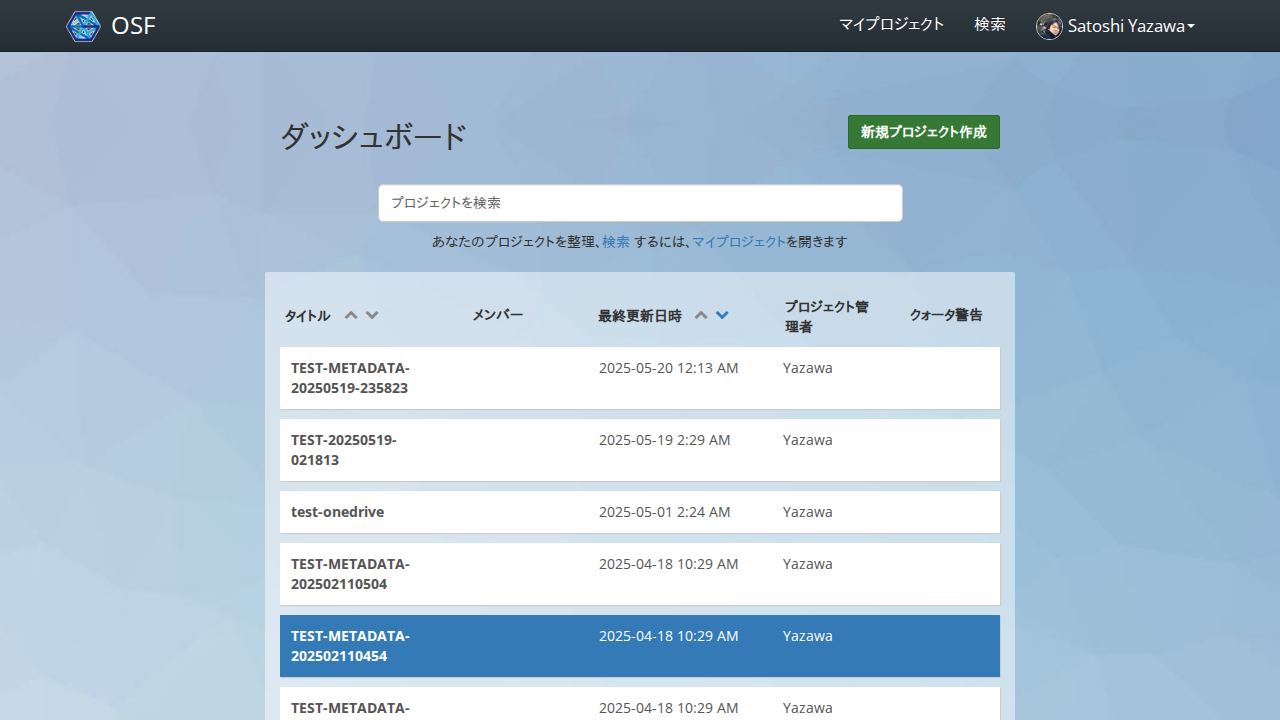

In [8]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    # GRDMのボタンが表示されることを確認
    await expect(page.locator('//*[text() = "プロジェクト管理者"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## ログインユーザー表示をクリックする

ドロップダウンに「設定」が現れること

Start epoch: 1747700639.693324 seconds


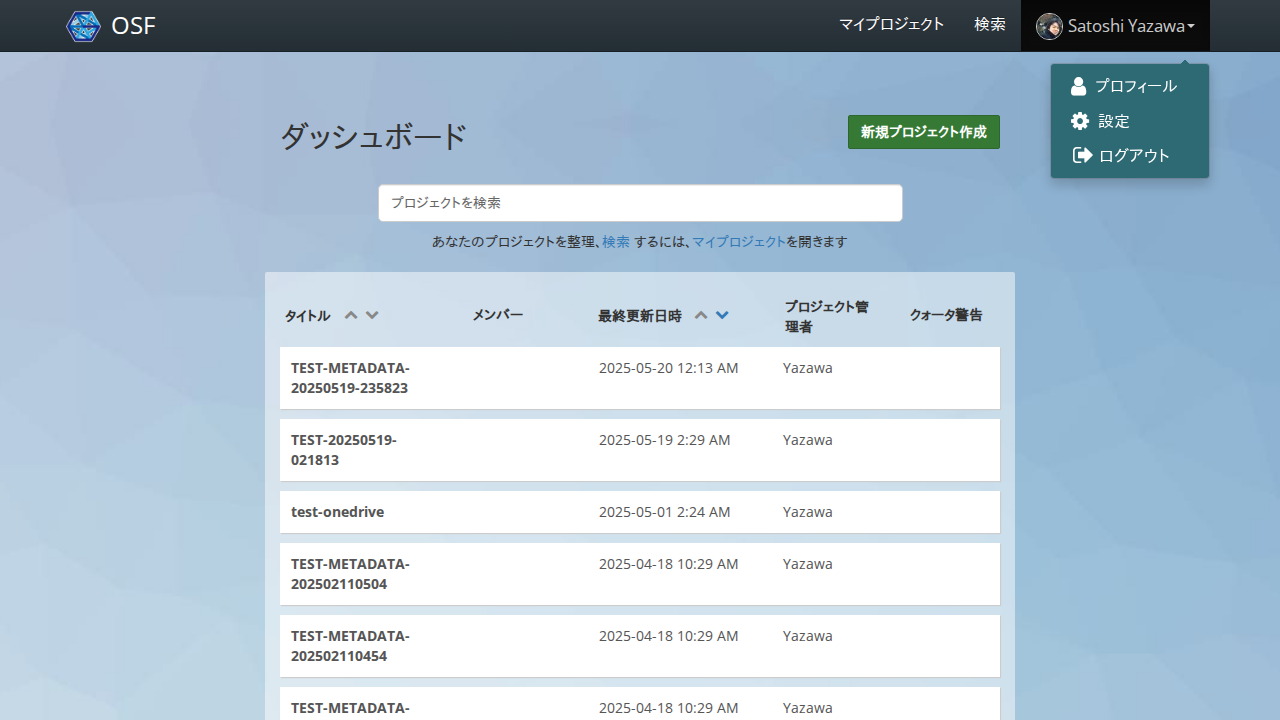

In [9]:
async def _step(page):
    await page.locator(f'//a[@data-test-auth-dropdown-toggle]').click()
    await expect(page.locator(f'//a[@data-test-ad-settings]')).to_be_visible(timeout=1000)

await run_pw(_step)

## 「設定」をクリックする

「プロフィール」画面が現れること

Start epoch: 1747700639.9260247 seconds


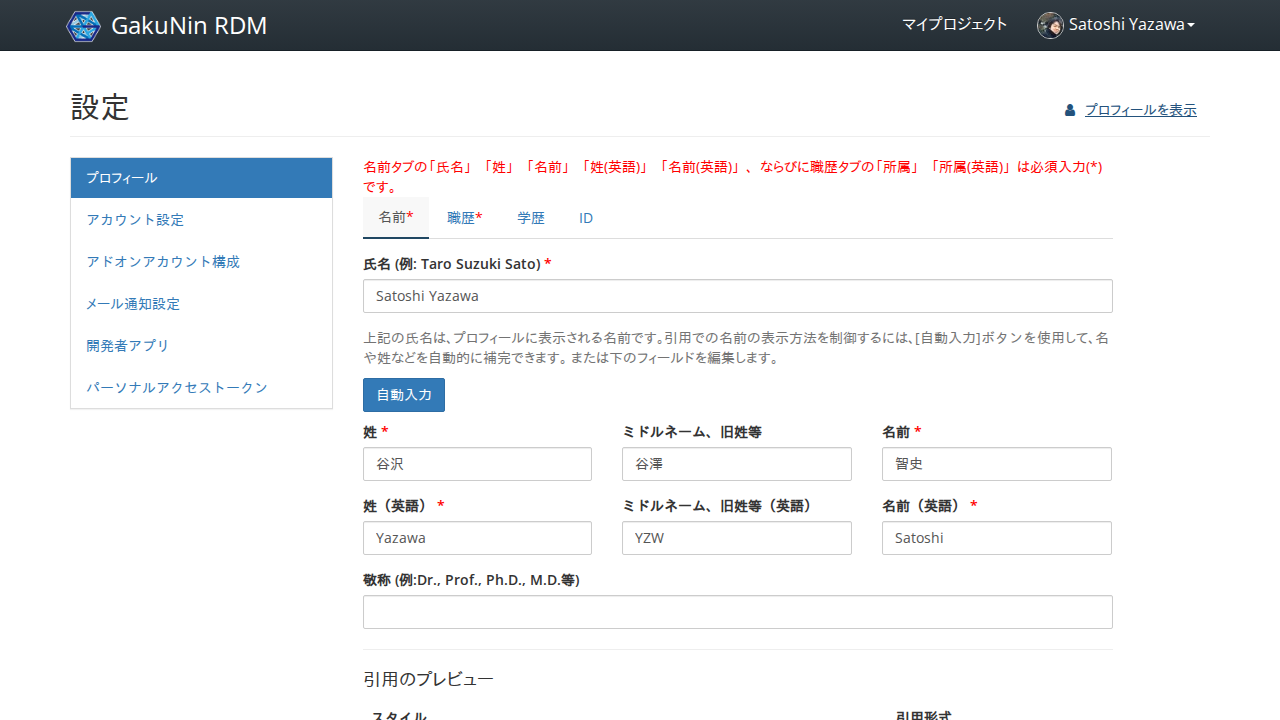

In [10]:
async def _step(page):
    await page.locator(f'//a[@data-test-ad-settings]').click()
    await expect(page.locator(f'//a[text() = "ID"]')).to_be_visible(timeout=1000)

await run_pw(_step)

## 「ID」をクリックする

「e-Rad研究者番号」画面が現れること

Start epoch: 1747700641.0851846 seconds


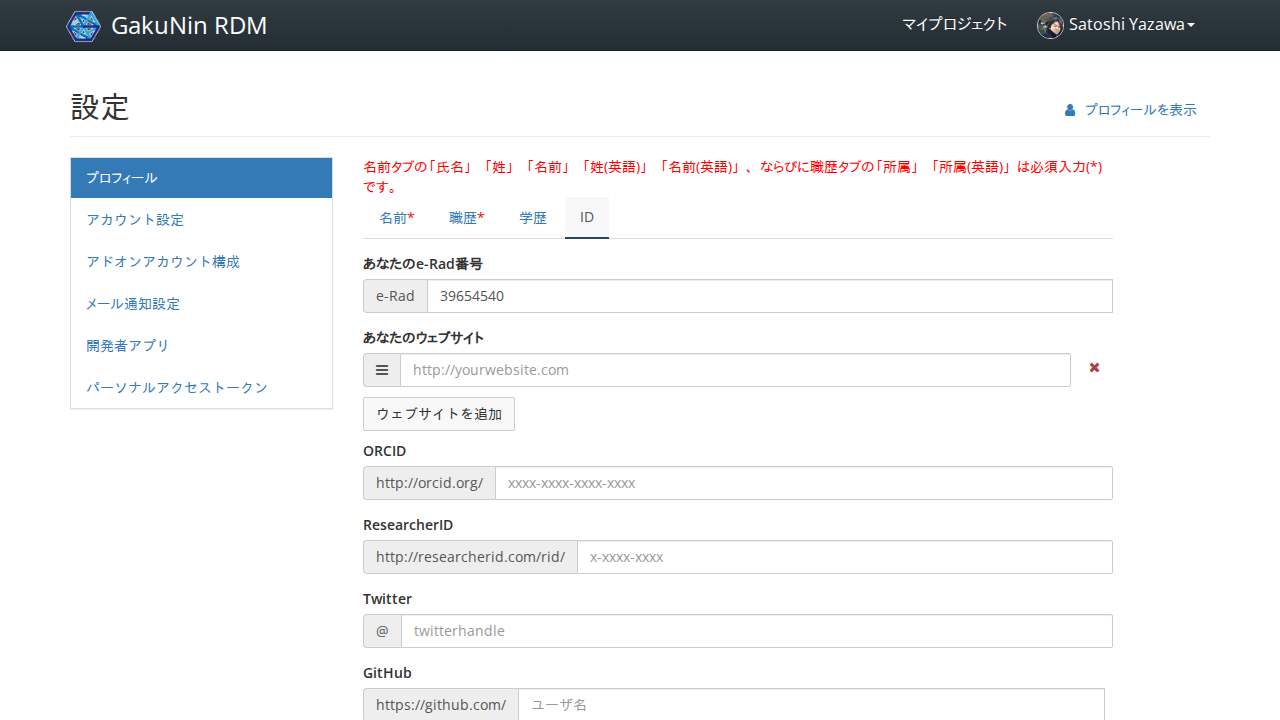

In [11]:
async def _step(page):
    await page.locator(f'//a[text() = "ID"]').click()
    await expect(page.locator(f'//input[@data-bind = "value: erad"]')).to_be_editable(timeout=1000)

await run_pw(_step)

## 「あなたのe-Rad番号」に「」(空文字列)を入力する

「e-Rad」の項目が空になること

Start epoch: 1747700641.3208325 seconds


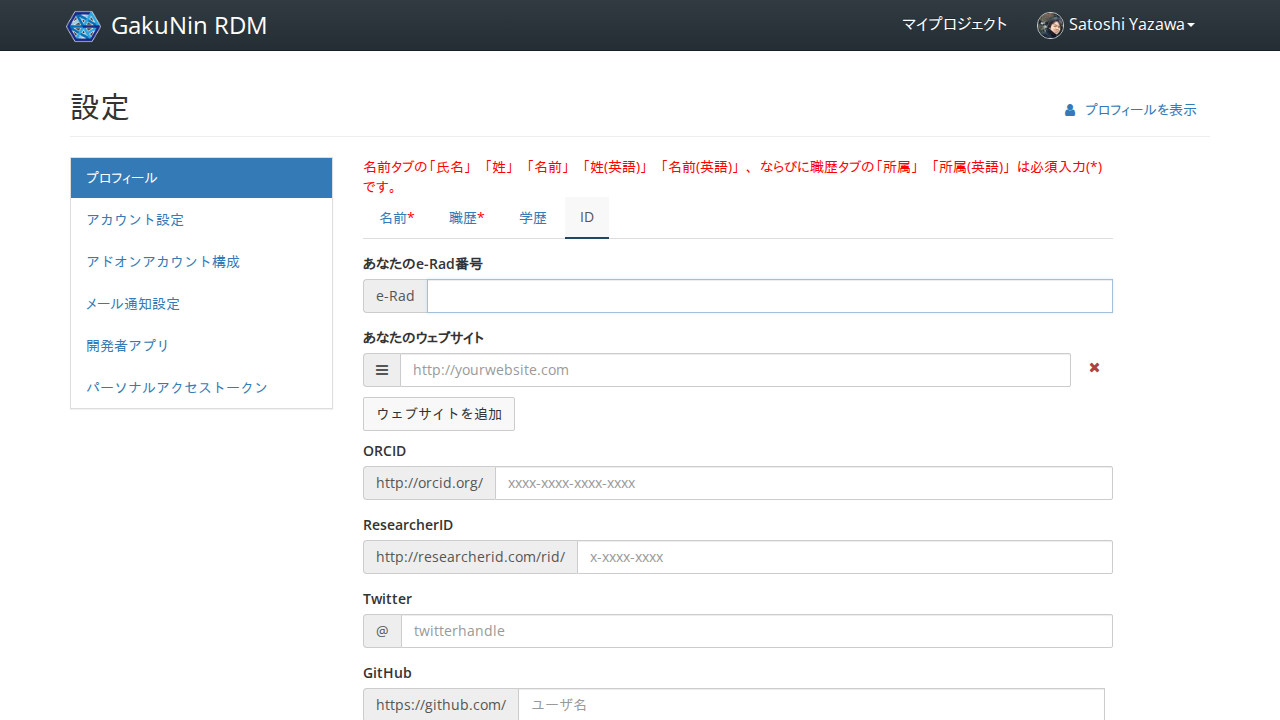

In [12]:
async def _step(page):
    await page.locator(f'//input[@data-bind = "value: erad"]').fill('')
    await expect(page.locator(f'//button[text() = "保存" and ancestor::div[contains(@class,"active")]]')).to_be_visible(timeout=1000)

await run_pw(_step)

## 「保存」をクリックする

「設定が更新されました」と緑色で表示されること

Start epoch: 1747700641.5084872 seconds


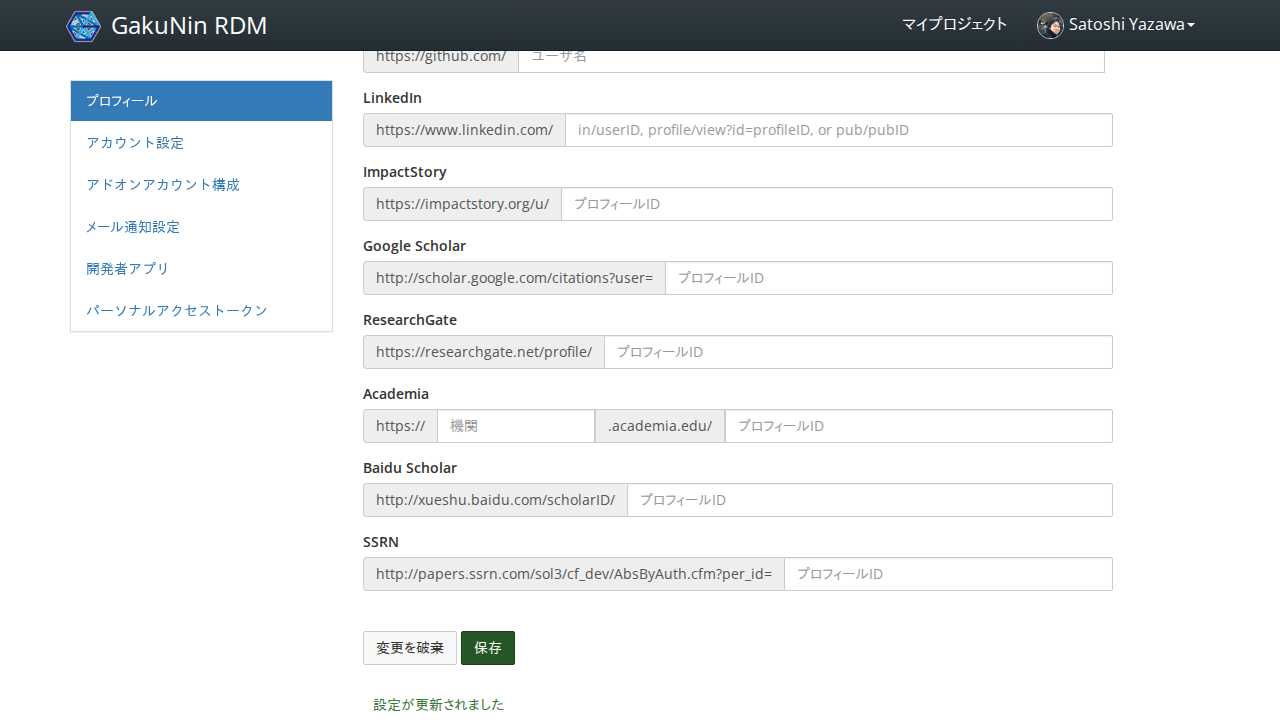

In [13]:
async def _step(page):
    await page.locator(f'//button[text() = "保存" and ancestor::div[contains(@class,"active")]]').click()
    await expect(page.locator(f'//p[contains(@class, "text-success") and contains(text(), "設定が更新されました")]')).to_be_visible(timeout=1000)

await run_pw(_step)

## ダッシュボードのURLを開く

GRDMダッシュボードが表示されること

In [14]:
from urllib.parse import urljoin

async def _step(page):
    await page.goto(urljoin(rdm_url, 'dashboard'))
    await expect(page.locator(f'//*[@data-test-dashboard-item-title and text() = "{rdm_project_name}"]')).to_be_visible(timeout=30000)
    time.sleep(1)

await run_pw(_step)

Start epoch: 1747700641.8555264 seconds
Screenshot: /tmp/tmpoozwk8tr/last-screenshot.png


AssertionError: Locator expected to be visible
Actual value: <element(s) not found> 
Call log:
  - LocatorAssertions.to_be_visible with timeout 30000ms
  - waiting for locator("//*[@data-test-dashboard-item-title and text() = \"TEST-METADATA-20250520-002232\"]")


## ダッシュボードのプロジェクト一覧から作成したプロジェクトをクリックする

作成したプロジェクトのプロジェクトダッシュボードが表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//*[@data-test-dashboard-item-title and text() = "{rdm_project_name}"]').click()
    
    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=10000)
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "NII Storage"]')).to_be_visible(timeout=10000)
    time.sleep(1)

await run_pw(_step)

## プロジェクトダッシュボードの上部メニューから「メタデータ」をクリックする

メタデータの一覧ページが表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//a[contains(text(), "メタデータ")]').click()
    await expect(page.locator('//*[@data-test-new-metadata-button]')).to_be_visible(timeout=10000)

await run_pw(_step)

## 「新規メタデータ」をクリックする

スキーマ選択ダイアログが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[@data-test-new-metadata-button]').click()

    await expect(page.locator('//*[@data-test-new-report-modal-schema="公的資金による研究データのメタデータ登録"]')).to_be_visible(timeout=transition_timeout)
    await expect(page.locator('//*[@data-test-new-report-modal-create-report-button]')).to_be_visible(timeout=10000)
    time.sleep(1)

await run_pw(_step)

## 「メタデータを作成」をクリックする

メタデータ編集ウィンドウが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[@data-test-new-report-modal-create-report-button]').click()
    
    await expect(page.locator('//*[contains(text(), "資金配分機関情報")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=transition_timeout)
    await expect(page.locator('//*[contains(text(), "体系的番号におけるプログラム情報コード")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "プログラム名 (日本語)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "Program name (English)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "体系的番号")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=1000)
    await expect(page.locator('//*[contains(text(), "プロジェクト名 (日本語)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "Project name (English)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "プロジェクトの分野")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=1000)

await run_pw(_step)

## 「体系的番号」をクリックする

ドロップダウンには補完候補は表示されないこと

In [ ]:
async def _step(page):
    await page.locator('//*[contains(text(), "体系的番号")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]').click()
    
    await expect(page.locator('//li[contains(@class, "ember-power-select-option--no-matches-message")]')).to_be_visible(timeout=1000)
    # await expect(page.locator('//*[contains(text(), "プロジェクト名 (日本語)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    # await expect(page.locator('//*[contains(text(), "Project name (English)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    # await expect(page.locator('//*[contains(text(), "プロジェクトの分野")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=1000)

await run_pw(_step)

## GRDMトップページを表示する

ダッシュボードのプロジェクト一覧に先に作成したプロジェクトが表示されること

In [ ]:
async def _step(page):
    await page.goto(urljoin(rdm_url, 'dashboard'))
    await expect(page.locator(f'//*[@data-test-dashboard-item-title and text() = "{rdm_project_name}"]')).to_be_visible(timeout=30000)
    time.sleep(1)

await run_pw(_step)

## ログインユーザー表示をクリックする

ドロップダウンに「設定」が現れること

In [ ]:
async def _step(page):
    await page.locator(f'//a[@data-test-auth-dropdown-toggle]').click()
    await expect(page.locator(f'//a[@data-test-ad-settings]')).to_be_visible(timeout=1000)

await run_pw(_step)

## 「設定」をクリックする

「プロフィール」画面が現れること

In [ ]:
async def _step(page):
    await page.locator(f'//a[@data-test-ad-settings]').click()
    await expect(page.locator(f'//a[text() = "ID"]')).to_be_visible(timeout=1000)

await run_pw(_step)

## 「ID」をクリックする

「e-Rad研究者番号」画面が現れること

In [ ]:
async def _step(page):
    await page.locator(f'//a[text() = "ID"]').click()
    await expect(page.locator(f'//input[@data-bind = "value: erad"]')).to_be_editable(timeout=1000)

await run_pw(_step)

## 「あなたのe-Rad番号」に「39654540」を入力する

「e-Rad」の項目に「39654540」が表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//input[@data-bind = "value: erad"]').fill('39654540')
    await expect(page.locator(f'//button[text() = "保存" and ancestor::div[contains(@class,"active")]]')).to_be_visible(timeout=1000)

await run_pw(_step)

## 「保存」をクリックする

「設定が更新されました」と緑色で表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//button[text() = "保存" and ancestor::div[contains(@class,"active")]]').click()
    await expect(page.locator(f'//p[contains(@class, "text-success") and contains(text(), "設定が更新されました")]')).to_be_visible(timeout=1000)

await run_pw(_step)

## ダッシュボードのURLを開く

GRDMダッシュボードが表示されること

In [ ]:
async def _step(page):
    await page.goto(urljoin(rdm_url, 'dashboard'))
    await expect(page.locator(f'//*[@data-test-dashboard-item-title and text() = "{rdm_project_name}"]')).to_be_visible(timeout=30000)
    time.sleep(1)

await run_pw(_step)

## ダッシュボードのプロジェクト一覧から作成したプロジェクトをクリックする

作成したプロジェクトのプロジェクトダッシュボードが表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//*[@data-test-dashboard-item-title and text() = "{rdm_project_name}"]').click()
    
    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=10000)
    await expect(page.locator('//*[contains(@class, "title-text")]//*[text() = "NII Storage"]')).to_be_visible(timeout=10000)
    time.sleep(1)

await run_pw(_step)

## 「NII Storage」をクリックする

「メタデータ編集」ボタンが表示されること (表示まで数秒かかる可能性がある)

In [ ]:
async def _step(page):
    target_storage_name = 'NII Storage'
    await grdm.get_select_expanded_storage_title_locator(page, target_storage_name).click()
    
    await expect(page.locator('//*[text() = "メタデータ編集"]')).to_be_enabled(timeout=10000)

await run_pw(_step)

## 「新規フォルダ作成」をクリックする

フォルダ名入力テキストフィールドが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "新規フォルダ作成"]').click()
    
    await expect(page.locator('//input[@id = "createFolderInput"]')).to_be_editable(timeout=1000)

await run_pw(_step)

## 「TESTMETADATA(ENTER)」を入力する

TESTMETADATAフォルダが作成されること

In [ ]:
async def _step(page):
    await page.locator('//input[@id = "createFolderInput"]').fill('TESTMETADATA')
    await page.keyboard.press('Enter')

    await expect(page.locator('//*[text() = "TESTMETADATA"]')).to_be_visible(timeout=10000)

await run_pw(_step)

## 「TESTMETADATA」をクリックする

「メタデータ編集」ボタンが表示されること (表示まで数秒かかる可能性がある)

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "TESTMETADATA"]').click()

    await expect(page.locator('//*[text() = "メタデータ編集"]')).to_be_enabled(timeout=1000)

await run_pw(_step)

##  「メタデータ編集」をクリックする

「メタデータ編集」ダイアログが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "メタデータ編集"]').click()

    await expect(page.locator('//label[contains(text(), "メタデータ様式")]/following-sibling::select')).to_be_editable(timeout=1000)
    time.sleep(1)

await run_pw(_step)

##  「メタデータ様式」に「公的資金による研究データのメタデータ登録」を入力する

「データNo.」フィールドが表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "メタデータ様式")]/following-sibling::select').select_option('公的資金による研究データのメタデータ登録')

    await expect(page.locator('//label[contains(text(), "データ No.")]/../following-sibling::div//input')).to_be_editable(timeout=1000)

await run_pw(_step)

##  「データ No.」の「入力」をクリックする

データNo.にファイルパスが表示されること

In [ ]:
async def _step(page):
    target_storage_id = 'osfstorage'
    await page.locator('//label[contains(text(), "データ No.")]/../following-sibling::div[1]//*[text() = "入力"]').click()

    await expect(page.locator('//label[contains(text(), "データ No.")]/../following-sibling::div[1]//input')).to_have_value(f'files/dir/{target_storage_id}/TESTMETADATA/', timeout=10000)

await run_pw(_step)

##  「データの名称(日本語)」に「テストデータ」を入力する

「このフィールドか「Title(English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    await expect(page.locator('//*[contains(text(), "このフィールドか「Title (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "データの名称 (日本語)")]/../following-sibling::div[1]//input').fill('テストデータ')
    await page.keyboard.press('Enter')

    await expect(page.locator('//*[contains(text(), "このフィールドか「Title (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Title (English)」に「Test Data」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "Title (English)")]/../following-sibling::div[1]//input').fill('Test Data')
    await page.keyboard.press('Enter')

    await expect(page.locator('//label[contains(text(), "Title (English)")]/../following-sibling::div[1]//input')).to_have_value('Test Data', timeout=1000)

await run_pw(_step)

##  「掲載日・掲載更新日」に「2022-05-25」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "掲載日・掲載更新日")]/../following-sibling::input').focus()
    await page.keyboard.type('2022-05-25')
    await page.keyboard.press('Tab')

    await expect(page.locator('//label[contains(text(), "掲載日・掲載更新日")]/../following-sibling::input')).to_have_value('2022-05-25', timeout=1000)

await run_pw(_step)

##  「データの説明 (日本語)」に「自動テストによって作成されたメタデータです。」を入力する

「このフィールドか「Description(English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    await expect(page.locator('//*[contains(text(), "このフィールドか「Description (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "データの説明 (日本語)")]/../following-sibling::textarea[1]').fill('自動テストによって作成されたメタデータです。')
    await page.keyboard.press('Tab')

    await expect(page.locator('//*[contains(text(), "このフィールドか「Description (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Description (English)」に「Metadata created by automated testing.」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "Description (English)")]/../following-sibling::textarea[1]').fill('Metadata created by automated testing.')
    await page.keyboard.press('Tab')

    await expect(page.locator('//label[contains(text(), "Description (English)")]/../following-sibling::textarea[1]')).to_have_value('Metadata created by automated testing.', timeout=1000)

await run_pw(_step)

##  「概略データ量」の「計算」をクリックする

「0B」と入力されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "概略データ量")]/../following-sibling::div[1]//*[text() = "計算"]').click()

    await expect(page.locator('//label[contains(text(), "概略データ量")]/../following-sibling::div[1]//input')).to_have_value('0B', timeout=10000)

await run_pw(_step)

##  「管理対象データの利活用・提供方針 (有償/無償)」に「無償」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = '管理対象データの利活用・提供方針 (有償/無償)'
    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "管理対象データの利活用・提供方針 (有償/無償)")]/../following-sibling::select[1]').select_option('無償')

    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「管理対象データの利活用・提供方針 (ライセンス)」に「CC BY 4.0 表示 国際」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = '管理対象データの利活用・提供方針 (ライセンス)'
    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "管理対象データの利活用・提供方針 (ライセンス)")]/../following-sibling::select[1]').select_option('CC BY 4.0 表示 国際')

    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「管理対象データの利活用・提供方針 (引用方法等・日本語)」に「利用方針をここに記載します。」を入力する

「このフィールドか「Data utilization and provision policy (citation information, English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    await expect(page.locator('//*[contains(text(), "このフィールドか「Data utilization and provision policy (citation information, English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "管理対象データの利活用・提供方針 (引用方法等・日本語)")]/../following-sibling::textarea[1]').fill('利用方針をここに記載します。')
    await page.keyboard.press('Tab')

    await expect(page.locator('//*[contains(text(), "このフィールドか「Data utilization and provision policy (citation information, English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Data utilization and provision policy (citation information, English)」に「The policy for use is described here.」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "Data utilization and provision policy (citation information, English)")]/../following-sibling::textarea[1]').fill('The policy for use is described here.')
    await page.keyboard.press('Tab')

    await expect(page.locator('//label[contains(text(), "Data utilization and provision policy (citation information, English)")]/../following-sibling::textarea[1]')).to_have_value('The policy for use is described here.', timeout=1000)

await run_pw(_step)

##  「アクセス権」に「公開」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = 'アクセス権'
    await expect(page.locator(f'//label[text() = "{label_text}"]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[text() = "アクセス権"]/../following-sibling::select[1]').select_option('公開')

    await expect(page.locator(f'//label[text() = "{label_text}"]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「リポジトリ情報 (日本語)」に「テストリポジトリ」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "リポジトリ情報 (日本語)")]/../following-sibling::div//input[1]')
    value = 'テストリポジトリ'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「Repository information (English)」に「Test Repository」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "Repository information (English)")]/../following-sibling::div//input[1]')
    value = 'Test Repository'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「リポジトリURL・DOIリンク」の「入力」をクリックする

フォルダのURLが表示されること

In [ ]:
from urllib.parse import urljoin

# URL置き換えフラグ
url_replaced = False

async def _step(page):
    global url_replaced
    target_storage_id = 'osfstorage'
    await page.locator('//label[contains(text(), "リポジトリURL・DOIリンク")]/../following-sibling::div[1]//*[text() = "入力"]').click()
    value = urljoin(page.url, f'files/dir/{target_storage_id}/TESTMETADATA/')

    await expect(page.locator('//label[contains(text(), "リポジトリURL・DOIリンク")]/../following-sibling::div[1]//input')).to_have_value(value, timeout=10000)
    if not value.startswith('http://localhost:5000/'):
        return
    # localhost:portはリポジトリURLとして許容されないので、置き換える
    value = value.replace('http://localhost:5000/', 'https://rdm.example.com/')
    await page.locator('//label[contains(text(), "リポジトリURL・DOIリンク")]/../following-sibling::div[1]//input').fill(value)
    url_replaced = True

await run_pw(_step)

##  「データ作成者」の「追加」をクリックする

作成者入力フィールドが表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div//*[text() = "追加"]').click()

    await expect(page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div//tbody/tr[1]/td[1]//input')).to_be_editable(timeout=10000)

await run_pw(_step)

##  「e-Rad研究者番号」に「0123456789」を入力する

フィールドに値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div[1]//tbody/tr[1]/td[1]//input')
    value = '0123456789'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「名前　(日本語)」に「情報太郎」を入力する

フィールドに値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div[1]//tbody/tr[1]/td[2]//input')
    value = '情報太郎'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「Name(English)」に「Taro Joho」を入力する

フィールドに値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div[1]//tbody/tr[1]/td[3]//input')
    value = 'Taro Joho'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「データ管理機関 (日本語)」に「国立情報学研究所」を入力する

「このフィールドか「Hosting institution (English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "このフィールドか「Hosting institution (English)」フィールドのいずれかを入力する必要があります。")]')
    await expect(required_locator).to_have_count(1, timeout=1000)
    locator = page.locator('//label[contains(text(), "データ管理機関 (日本語)")]/../following-sibling::div[1]//input')
    value = '国立情報学研究所'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Hosting institution (English)」に「National Institute of Informatics」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "Hosting institution (English)")]/../following-sibling::div[1]//input')
    value = 'National Institute of Informatics'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

## 「データ管理機関コード」に「 https://ror.org/DUMMY 」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理機関コード")]/../following-sibling::div[1]//input')
    value = 'https://ror.org/DUMMY'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

## 「データ管理者の種類」にて「個人」を選択する

すでに値が表示されている場合は選択不要。「個人」が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理者の種類")]/../following-sibling::select[1]')
    value = '個人'
    await locator.select_option(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value('individual', timeout=1000)

await run_pw(_step)

##  「データ管理者の e-Rad 研究者番号」に「0123456789」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理者の e-Rad 研究者番号")]/../following-sibling::div[1]//input')
    value = '0123456789'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「データ管理者 (日本語)」に「情報花子」を入力する

「このフィールドか「Data manager (English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "このフィールドか「Data manager (English)」フィールドのいずれかを入力する必要があります。")]')
    await expect(required_locator).to_have_count(1, timeout=1000)
    locator = page.locator('//label[contains(text(), "データ管理者 (日本語)")]/../following-sibling::div[1]//input')
    value = '情報花子'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Data manager (English)」に「Hanako Joho」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "Data manager (English")]/../following-sibling::div[1]//input')
    value = 'Hanako Joho'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「データ管理者の所属組織名(日本語)」に「テストセンター」を入力する

値が表示されること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(6, timeout=1000)
    locator = page.locator('//label[contains(text(), "データ管理者の所属組織名")]/../following-sibling::div[1]//input')
    value = 'テストセンター'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(4, timeout=1000)

await run_pw(_step)

##  「Contact organization of data manager (English)」に「Test Center」を入力する

値が表示されること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(4, timeout=1000)
    locator = page.locator('//label[contains(text(), "Contact organization of data manager (English)")]/../following-sibling::div[1]//input')
    value = 'Test Center'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(4, timeout=1000)

await run_pw(_step)

##  「データ管理者の所属機関の連絡先住所 (日本語)」に「テスト住所」を入力する

値が表示されること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(4, timeout=1000)
    locator = page.locator('//label[contains(text(), "データ管理者の所属機関の連絡先住所 (日本語)")]/../following-sibling::div[1]//input')
    value = 'テスト住所'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(2, timeout=1000)

await run_pw(_step)

##  「Contact address of data manager (English)」に「Test Address」を入力する

値が表示されること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(2, timeout=1000)
    locator = page.locator('//label[contains(text(), "Contact address of data manager (English)")]/../following-sibling::div[1]//input')
    value = 'Test Address'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(2, timeout=1000)

await run_pw(_step)

##  「データ管理者の所属機関の連絡先電話番号」に「000-0000-0000」を入力する

「「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(2, timeout=1000)
    locator = page.locator('//label[contains(text(), "データ管理者の所属機関の連絡先電話番号")]/../following-sibling::div[1]//input')
    value = '000-0000-0000'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「データ管理者の所属機関の連絡先メールアドレス」に「test@example.com」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理者の所属機関の連絡先メールアドレス")]/../following-sibling::div[1]//input')
    value = 'test@test.nii.ac.jp'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「備考 (日本語)」に「日本語による備考です。」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "備考 (日本語)")]/../following-sibling::textarea[1]')
    value = '日本語による備考です。'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「Remarks (English)」に「Remarks in English.」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "Remarks (English)")]/../following-sibling::textarea[1]')
    value = 'Remarks in English.'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「メタデータのアクセス権」に「公開」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = 'メタデータのアクセス権'
    required_locator = page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')
    await expect(required_locator).to_have_count(1, timeout=1000)
    locator = page.locator('//label[contains(text(), "メタデータのアクセス権")]/../following-sibling::select[1]')
    value = '公開'
    await locator.select_option(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value('open access', timeout=1000)
    await expect(required_locator).to_have_count(0, timeout=1000)

await run_pw(_step)

## 「保存」をクリックする

ダイアログが非表示になること

In [ ]:
async def _step(page):
    await page.locator('//a[text() = "保存"]').click()
    await expect(page.locator('//label[contains(text(), "メタデータのアクセス権")]/../following-sibling::select[1]')).not_to_be_visible(timeout=10000)

await run_pw(_step)

## プロジェクトダッシュボードの上部メニューから「メタデータ」をクリックする

メタデータの一覧ページが表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//a[contains(text(), "メタデータ")]').click()
    await expect(page.locator('//*[@data-test-new-metadata-button]')).to_be_visible(timeout=10000)

await run_pw(_step)

## 「下書き」をクリックする

メタデータの一覧ページが表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//a[text() = "下書き"]').click()
    await expect(page.locator('//*[@data-analytics-name = "Edit"]')).to_be_visible(timeout=10000)

await run_pw(_step)

## 「編集」をクリックする

メタデータ編集ウィンドウが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[@data-analytics-name = "Edit"]').click()
    
    await expect(page.locator('//*[contains(text(), "資金配分機関情報")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=transition_timeout)
    await expect(page.locator('//*[contains(text(), "体系的番号におけるプログラム情報コード")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "プログラム名 (日本語)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "Program name (English)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "体系的番号")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=1000)
    await expect(page.locator('//*[contains(text(), "プロジェクト名 (日本語)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "Project name (English)")]/../following-sibling::div[1]//input')).to_be_editable(timeout=1000)
    await expect(page.locator('//*[contains(text(), "プロジェクトの分野")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=1000)

await run_pw(_step)

## 「体系的番号」をクリックする

ダミーデータから候補が表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[contains(text(), "体系的番号")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]').click()
    
    await expect(page.locator('//li[contains(@class, "ember-power-select-option") and @data-option-index = "0"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 2番目の候補をクリックする

資金配分機関情報, 体系的番号におけるプログラム情報コード, 体系的番号, プログラム名(日本語), プロジェクト名(日本語), プロジェクトの分野が入力されること

In [ ]:
async def _step(page):
    # Select "犯罪者の研究" explicitly instead of using index
    # Use . instead of text() to match text in descendant elements as well
    await page.locator('//li[contains(@class, "ember-power-select-option") and contains(., "犯罪者の研究")]').click()
    
    await expect(page.locator('//*[contains(text(), "資金配分機関情報")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-selected-item")]')).not_to_have_text('', timeout=transition_timeout)
    await expect(page.locator('//*[contains(text(), "体系的番号におけるプログラム情報コード")]/../following-sibling::div[1]//input')).not_to_have_value('', timeout=1000)
    await expect(page.locator('//*[contains(text(), "体系的番号")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-selected-item")]')).not_to_have_text('', timeout=1000)
    await expect(page.locator('//*[contains(text(), "プログラム名 (日本語)")]/../following-sibling::div[1]//input')).not_to_have_value('', timeout=1000)
    await expect(page.locator('//*[contains(text(), "プロジェクト名 (日本語)")]/../following-sibling::div[1]//input')).not_to_have_value('', timeout=1000)
    await expect(page.locator('//*[contains(text(), "プロジェクトの分野")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-selected-item")]')).not_to_have_text('', timeout=1000)

await run_pw(_step)

## 「Project name (English)」に「Sample Metadata Project」を入力する

テキストフィールドに値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[contains(text(), "Project name (English)")]/../following-sibling::div[1]//input').fill('Sample Metadata Project')
    
    await expect(page.locator('//*[contains(text(), "Project name (English)")]/../following-sibling::div[1]//input')).to_have_value('Sample Metadata Project', timeout=1000)
    # await expect(page.locator('//*[contains(text(), "プロジェクトの分野")]/../following-sibling::div[1]//*[contains(@class, "ember-power-select-status-icon")]')).to_be_attached(timeout=1000)

await run_pw(_step)

## 「次へ」をクリックする

左側ペイン「メタデータ登録」が緑色かつチェックマークが表示されること

In [ ]:
import re

async def _step(page):
    await page.locator('//*[@data-test-goto-next-page]').click()
    
    await expect(page.locator('//span[@data-test-label and text() = "メタデータ登録"]/../preceding-sibling::i')).to_have_class(re.compile(r'.*fa-check-circle-o.*'), timeout=1000)

await run_pw(_step)

## 「登録データ一覧」の「テストデータ」をクリックする

プロジェクトのファイルタブが表示されること

In [ ]:
async def _step(page):
    # リンクのhrefを取得
    link_locator = page.locator('//a[@target = "_blank" and text() = "テストデータ"]')
    href = await link_locator.get_attribute('href')
    
    # URL置き換えが発生していた場合、rdm.example.comをlocalhost:5000に戻す
    if url_replaced and href and href.startswith('https://rdm.example.com/'):
        href = href.replace('https://rdm.example.com/', 'http://localhost:5000/')
    
    # 新しいタブを開く
    popup_future = page.wait_for_event('popup')
    await page.evaluate(f'window.open("{href}", "_blank")')
    popup = await popup_future
    
    await expect(popup.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=30000)
    await expect(popup.locator('//*[contains(@class, "title-text")]//*[text() = "NII Storage"]')).to_be_visible(timeout=10000)
    time.sleep(1)
    return popup

await run_pw(_step)

## 「NII Storage」をクリックする

「メタデータ編集」ボタンが表示されること (表示まで数秒かかる可能性がある)

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "NII Storage"]').click()
    
    await expect(page.locator('//*[text() = "メタデータ編集"]')).to_be_enabled(timeout=10000)

await run_pw(_step)

## ファイルをアップロードする

テスト環境の「sample.png」をNII Storage配下にドラッグ＆ドロップする。

In [ ]:
await save_screenshot(os.path.join(work_dir, 'sample.png'))

In [ ]:
# import scripts.grdm
# importlib.reload(scripts.grdm)

async def _step(page):
    dropzone = grdm.get_select_storage_title_xpath('NII Storage')
    await grdm.drop_file(page, dropzone, os.path.join(work_dir, 'sample.png'))
    time.sleep(1)

    await grdm.wait_for_uploaded(page, 'sample.png')

await run_pw(_step)

## 「sample.png」をクリックする

「メタデータ編集」ボタンが表示されること (表示まで数秒かかる可能性がある)

In [ ]:
async def _step(page):
    await grdm.get_select_file_extension_locator(page, 'sample.png').click()
    await expect(page.locator('//*[text() = "メタデータ編集"]')).to_be_enabled(timeout=10000)

await run_pw(_step)

##  「メタデータ編集」をクリックする

「メタデータ編集」ダイアログが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "メタデータ編集"]').click()

    await expect(page.locator('//label[contains(text(), "メタデータ様式")]/following-sibling::select')).to_be_editable(timeout=1000)
    time.sleep(1)

await run_pw(_step)

##  「メタデータ様式」に「公的資金による研究データのメタデータ登録」を入力する

「データNo.」フィールドが表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "メタデータ様式")]/following-sibling::select').select_option('公的資金による研究データのメタデータ登録')

    await expect(page.locator('//label[contains(text(), "データ No.")]/../following-sibling::div//input')).to_be_editable(timeout=1000)

await run_pw(_step)

##  「データ No.」の「入力」をクリックする

データNo.に5桁のIDが表示されること

In [ ]:
import re

async def _step(page):
    await page.locator('//label[contains(text(), "データ No.")]/../following-sibling::div[1]//*[text() = "入力"]').click()

    await expect(page.locator('//label[contains(text(), "データ No.")]/../following-sibling::div[1]//input')).to_have_value(re.compile(r'[0-9a-z]{5}'), timeout=10000)

await run_pw(_step)

##  「データの名称(日本語)」に「テストデータ」を入力する

「このフィールドか「Title(English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    await expect(page.locator('//*[contains(text(), "このフィールドか「Title (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "データの名称 (日本語)")]/../following-sibling::div[1]//input').fill('テストデータ')
    await page.keyboard.press('Enter')

    await expect(page.locator('//*[contains(text(), "このフィールドか「Title (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Title (English)」に「Test Data」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "Title (English)")]/../following-sibling::div[1]//input').fill('Test Data')
    await page.keyboard.press('Enter')

    await expect(page.locator('//label[contains(text(), "Title (English)")]/../following-sibling::div[1]//input')).to_have_value('Test Data', timeout=1000)

await run_pw(_step)

##  「掲載日・掲載更新日」に「2022-05-25」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "掲載日・掲載更新日")]/../following-sibling::input').focus()
    await page.keyboard.type('2022-05-25')
    await page.keyboard.press('Tab')

    await expect(page.locator('//label[contains(text(), "掲載日・掲載更新日")]/../following-sibling::input')).to_have_value('2022-05-25', timeout=1000)

await run_pw(_step)

##  「データの説明 (日本語)」に「自動テストによって作成されたメタデータです。」を入力する

「このフィールドか「Description(English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    await expect(page.locator('//*[contains(text(), "このフィールドか「Description (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "データの説明 (日本語)")]/../following-sibling::textarea[1]').fill('自動テストによって作成されたメタデータです。')
    await page.keyboard.press('Tab')

    await expect(page.locator('//*[contains(text(), "このフィールドか「Description (English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Description (English)」に「Metadata created by automated testing.」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "Description (English)")]/../following-sibling::textarea[1]').fill('Metadata created by automated testing.')
    await page.keyboard.press('Tab')

    await expect(page.locator('//label[contains(text(), "Description (English)")]/../following-sibling::textarea[1]')).to_have_value('Metadata created by automated testing.', timeout=1000)

await run_pw(_step)

##  「データの分野」に「プロジェクトの研究分野」を入力する

すでに設定されている場合は操作不要。「プロジェクトの研究分野」が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "データの分野")]/../following-sibling::select[1]').select_option('プロジェクトの研究分野')
    await expect(page.locator('//label[contains(text(), "データの分野")]/../following-sibling::select[1]')).to_have_value('project')

await run_pw(_step)

##  「データ種別」に「ゲノムデータ」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "データ種別")]/../following-sibling::select[1]').select_option('ゲノムデータ')
    await expect(page.locator('//label[contains(text(), "データ種別")]/../following-sibling::select[1]')).to_have_value('genomic data')

await run_pw(_step)

##  「概略データ量」の「計算」をクリックする

アップロードしたsample.pngのファイルサイズが表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "概略データ量")]/../following-sibling::div[1]//*[text() = "計算"]').click()

    await expect(page.locator('//label[contains(text(), "概略データ量")]/../following-sibling::div[1]//input')).to_have_value(re.compile(r'[0-9\.]+KB'), timeout=10000)

await run_pw(_step)

##  「管理対象データの利活用・提供方針 (有償/無償)」に「無償」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = '管理対象データの利活用・提供方針 (有償/無償)'
    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "管理対象データの利活用・提供方針 (有償/無償)")]/../following-sibling::select[1]').select_option('無償')

    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「管理対象データの利活用・提供方針 (ライセンス)」に「CC BY 4.0 表示 国際」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = '管理対象データの利活用・提供方針 (ライセンス)'
    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "管理対象データの利活用・提供方針 (ライセンス)")]/../following-sibling::select[1]').select_option('CC BY 4.0 表示 国際')

    await expect(page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「管理対象データの利活用・提供方針 (引用方法等・日本語)」に「利用方針をここに記載します。」を入力する

「このフィールドか「Data utilization and provision policy (citation information, English)」フィールドのいずれかを入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    await expect(page.locator('//*[contains(text(), "このフィールドか「Data utilization and provision policy (citation information, English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "管理対象データの利活用・提供方針 (引用方法等・日本語)")]/../following-sibling::textarea[1]').fill('利用方針をここに記載します。')
    await page.keyboard.press('Tab')

    await expect(page.locator('//*[contains(text(), "このフィールドか「Data utilization and provision policy (citation information, English)」フィールドのいずれかを入力する必要があります。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「Data utilization and provision policy (citation information, English)」に「The policy for use is described here.」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "Data utilization and provision policy (citation information, English)")]/../following-sibling::textarea[1]').fill('The policy for use is described here.')
    await page.keyboard.press('Tab')

    await expect(page.locator('//label[contains(text(), "Data utilization and provision policy (citation information, English)")]/../following-sibling::textarea[1]')).to_have_value('The policy for use is described here.', timeout=1000)

await run_pw(_step)

##  「アクセス権」に「公開期間猶予」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = 'アクセス権'
    await expect(page.locator(f'//label[text() = "{label_text}"]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[text() = "アクセス権"]/../following-sibling::select[1]').select_option('公開期間猶予')

    await expect(page.locator(f'//label[text() = "{label_text}"]/../../*[contains(text(), "このフィールドは必須項目です。")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「公開予定日 (公開期間猶予の場合)」に「2022-05-25」を入力する

「公開期間猶予の場合は必須項目です」が表示されなくなること

In [ ]:
async def _step(page):
    await expect(page.locator('//*[contains(text(), "公開期間猶予の場合は必須項目です")]')).to_have_count(1, timeout=1000)
    await page.locator('//label[contains(text(), "公開予定日 (公開期間猶予の場合)")]/../following-sibling::input').focus()
    await page.keyboard.type('2022-05-25')
    await page.keyboard.press('Tab')

    await expect(page.locator('//label[contains(text(), "公開予定日 (公開期間猶予の場合)")]/../following-sibling::input')).to_have_value('2022-05-25', timeout=1000)
    await expect(page.locator('//*[contains(text(), "公開期間猶予の場合は必須項目です")]')).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「リポジトリ情報 (日本語)」に「テストリポジトリ」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "リポジトリ情報 (日本語)")]/../following-sibling::div//input[1]')
    value = 'テストリポジトリ'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「Repository information (English)」に「Test Repository」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "Repository information (English)")]/../following-sibling::div//input[1]')
    value = 'Test Repository'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「リポジトリURL・DOIリンク」の「入力」をクリックする

ファイルのURLが表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "リポジトリURL・DOIリンク")]/../following-sibling::div[1]//*[text() = "入力"]').click()
    value = re.compile(r'.+files\/osfstorage\/[0-9a-f]+$')

    await expect(page.locator('//label[contains(text(), "リポジトリURL・DOIリンク")]/../following-sibling::div[1]//input')).to_have_value(value, timeout=10000)
    
    # Get actual value and replace if it's localhost
    actual_value = await page.locator('//label[contains(text(), "リポジトリURL・DOIリンク")]/../following-sibling::div[1]//input').input_value()
    if actual_value.startswith('http://localhost:5000/'):
        # localhost:portはリポジトリURLとして許容されないので、置き換える
        actual_value = actual_value.replace('http://localhost:5000/', 'https://rdm.example.com/')
        await page.locator('//label[contains(text(), "リポジトリURL・DOIリンク")]/../following-sibling::div[1]//input').fill(actual_value)

await run_pw(_step)

##  「データ作成者」の「追加」をクリックする

作成者入力フィールドが表示されること

In [ ]:
async def _step(page):
    await page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div//*[text() = "追加"]').click()

    await expect(page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div//tbody/tr[1]/td[1]//input')).to_be_editable(timeout=10000)

await run_pw(_step)

##  「e-Rad研究者番号」に「3」を入力する

フィールドに候補「情報|陽一」が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div[1]//tbody/tr[1]/td[1]//input')
    await locator.fill('')
    await locator.focus()
    await page.keyboard.press('3')

    await expect(page.locator('//*[contains(text(), "情報|陽一")]')).to_have_count(2, timeout=10000)

await run_pw(_step)

## 「情報|陽一」をクリックする

「名前 (日本語)」, 「Name (English)」が入力されること

In [ ]:
async def _step(page):
    await page.locator('(//*[contains(text(), "情報|陽一")])[1]').click()
    
    await expect(page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div[1]//tbody/tr[1]/td[2]//input')).to_have_value(re.compile('.+'), timeout=1000)
    await expect(page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div//tbody/tr[1]/td[3]//input')).to_have_value(re.compile('.+'))
    await expect(page.locator('//label[contains(text(), "データ作成者")]/../following-sibling::div//tbody/tr[1]/td[3]//input')).to_have_value(re.compile('.+'))

await run_pw(_step)

## 「データ管理者の種類」にて「個人」を選択する

すでに値が表示されている場合は選択不要。「個人」が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理者の種類")]/../following-sibling::select[1]')
    value = '個人'
    await locator.select_option(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value('individual', timeout=1000)

await run_pw(_step)

##  「データ管理者の e-Rad 研究者番号」に「3」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理者の e-Rad 研究者番号")]/../following-sibling::div[1]//input')
    await locator.focus()
    await page.keyboard.press('3')

    await expect(page.locator('//*[contains(text(), "情報|陽一")]')).to_have_count(2, timeout=10000)

await run_pw(_step)

## 「情報|陽一」をクリックする

「データ管理者 (日本語)」「Data manager (English)」「データ管理者の所属組織名 (日本語)」, 「Contact organization of data manager (English)」が入力されること


In [ ]:
async def _step(page):
    await page.locator('(//*[contains(text(), "情報|陽一")])[1]').click()
    
    await expect(page.locator('//label[contains(text(), "データ管理者の所属組織名 (日本語)")]/../following-sibling::div[1]//input')).to_have_value(re.compile('.+'), timeout=1000)
    await expect(page.locator('//label[contains(text(), "Contact organization of data manager (English)")]/../following-sibling::div[1]//input')).to_have_value(re.compile('.+'), timeout=1000)
    await expect(page.locator('//label[contains(text(), "データ管理機関コード")]/../following-sibling::div[1]//input')).to_have_value('')
    await expect(page.locator('//label[contains(text(), "データ管理者 (日本語)")]/../following-sibling::div[1]//input')).to_have_value(re.compile('.+'))
    await expect(page.locator('//label[contains(text(), "Data manager (English")]/../following-sibling::div[1]//input')).to_have_value(re.compile('.+'))

await run_pw(_step)

##  「データ管理機関 (日本語)」に「東京」を入力する

入力候補が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理機関 (日本語)")]/../following-sibling::div[1]//input')
    await locator.focus()
    await page.keyboard.type('東京')

    await expect(page.locator('//*[contains(text(), "The University of Tokyo")]')).to_have_count(1, timeout=10000)

await run_pw(_step)

## 「東京大学」をクリックする

「データ管理機関コード」, 「Hosting institution (English)」が入力されること


In [ ]:
async def _step(page):
    await page.locator('//*[contains(text(), "The University of Tokyo")]').click()
    
    await expect(page.locator('//label[contains(text(), "データ管理機関 (日本語)")]/../following-sibling::div[1]//input')).to_have_value('東京大学', timeout=1000)
    await expect(page.locator('//label[contains(text(), "Hosting institution (English)")]/../following-sibling::div[1]//input')).to_have_value('The University of Tokyo')
    await expect(page.locator('//label[contains(text(), "データ管理機関コード")]/../following-sibling::div[1]//input')).to_have_value('https://ror.org/057zh3y96')

await run_pw(_step)

##  「データ管理者の所属機関の連絡先住所 (日本語)」に「テスト住所」を入力する

値が表示されること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(4, timeout=1000)
    locator = page.locator('//label[contains(text(), "データ管理者の所属機関の連絡先住所 (日本語)")]/../following-sibling::div[1]//input')
    value = 'テスト住所'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(2, timeout=1000)

await run_pw(_step)

##  「Contact address of data manager (English)」に「Test Address」を入力する

値が表示されること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(2, timeout=1000)
    locator = page.locator('//label[contains(text(), "Contact address of data manager (English)")]/../following-sibling::div[1]//input')
    value = 'Test Address'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(2, timeout=1000)

await run_pw(_step)

##  「データ管理者の所属機関の連絡先電話番号」に「000-0000-0000」を入力する

「「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。」が表示されなくなること

In [ ]:
async def _step(page):
    required_locator = page.locator('//*[contains(text(), "「データ管理者の所属機関の連絡先メールアドレス」を入力する必要があります。もしくは、「データ管理者の所属組織名」(日英どちらか)および「データ管理者の所属機関の連絡先住所」(日英どちらか)、「データ管理者の所属機関の連絡先電話番号」を入力する必要があります。")]')
    await expect(required_locator).to_have_count(2, timeout=1000)
    locator = page.locator('//label[contains(text(), "データ管理者の所属機関の連絡先電話番号")]/../following-sibling::div[1]//input')
    value = '000-0000-0000'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)
    await expect(required_locator).to_have_count(0, timeout=1000)

await run_pw(_step)

##  「データ管理者の所属機関の連絡先メールアドレス」に「test@example.com」を入力する

入力した値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "データ管理者の所属機関の連絡先メールアドレス")]/../following-sibling::div[1]//input')
    value = 'test@test.nii.ac.jp'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「備考 (日本語)」に「日本語による備考です。」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "備考 (日本語)")]/../following-sibling::textarea[1]')
    value = '日本語による備考です。'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「Remarks (English)」に「Remarks in English.」を入力する

値が表示されること

In [ ]:
async def _step(page):
    locator = page.locator('//label[contains(text(), "Remarks (English)")]/../following-sibling::textarea[1]')
    value = 'Remarks in English.'
    await locator.fill(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value(value, timeout=1000)

await run_pw(_step)

##  「メタデータのアクセス権」に「公開」を入力する

「このフィールドは必須項目です。」が表示されなくなること

In [ ]:
async def _step(page):
    label_text = 'メタデータのアクセス権'
    required_locator = page.locator(f'//label[contains(text(), "{label_text}")]/../../*[contains(text(), "このフィールドは必須項目です。")]')
    await expect(required_locator).to_have_count(1, timeout=1000)
    locator = page.locator('//label[contains(text(), "メタデータのアクセス権")]/../following-sibling::select[1]')
    value = '公開'
    await locator.select_option(value)
    await page.keyboard.press('Tab')

    await expect(locator).to_have_value('open access', timeout=1000)
    await expect(required_locator).to_have_count(0, timeout=1000)

await run_pw(_step)

## 「保存」をクリックする

ダイアログが非表示になること

In [ ]:
async def _step(page):
    await page.locator('//a[text() = "保存"]').click()
    await expect(page.locator('//label[contains(text(), "メタデータのアクセス権")]/../following-sibling::select[1]')).not_to_be_visible(timeout=10000)

await run_pw(_step)

## 「sample.png」をクリックする

「メタデータ登録」ボタンが表示されること

In [ ]:
async def _step(page):
    await grdm.get_select_file_extension_locator(page, 'sample.png').click()
    await expect(page.locator('//*[text() = "メタデータ登録"]')).to_be_enabled(timeout=10000)

await run_pw(_step)

##  「メタデータ登録」をクリックする

「ファイルメタデータ登録先の選択」ダイアログが表示され、「サンプルメタデータプロジェクト」とチェックボックスが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "メタデータ登録"]').click()
    await expect(page.locator('//input[starts-with(@id, "draft-")]')).to_have_count(1, timeout=10000)

await run_pw(_step)

##  「犯罪者の研究」をクリックする

チェックボックスがチェック状態になること

In [ ]:
async def _step(page):
    checkbox = page.locator('//input[starts-with(@id, "draft-")]')
    await checkbox.click()
    await expect(checkbox).to_be_checked(timeout=10000)

await run_pw(_step)

##  「選択」をクリックする

「サンプルメタデータプロジェクト」に「開く」リンクが現れること

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "選択"]').click()
    await expect(page.locator('//*[text() = "開く"]')).to_be_enabled(timeout=10000)

await run_pw(_step)

## 「開く」をクリックする

ワークフローメタデータ編集画面が表示され、登録データ一覧に「テストデータ」が表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[text() = "開く"]').click()
    await expect(page.locator('//*[@data-test-goto-review]')).to_be_visible(timeout=10000)

await run_pw(_step)

## 「内容確認」をクリックする

左側ペイン「登録データ」が緑色かつチェックマークが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[@data-test-goto-review]').click()
    
    await expect(page.locator('//span[@data-test-label and text() = "登録データ"]/../preceding-sibling::i')).to_have_class(re.compile(r'.*fa-check-circle-o.*'), timeout=1000)

await run_pw(_step)

## 「登録」をクリックする

「登録する前に...」メッセージが表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[@data-test-goto-register]').click()
    
    await expect(page.locator('//*[@data-test-submit-registration-button]')).to_be_enabled(timeout=transition_timeout)
    time.sleep(1)

await run_pw(_step)

## 「登録」をクリックする

メタデータ一覧画面が表示されること

In [ ]:
async def _step(page):
    await page.locator('//*[@data-test-submit-registration-button]').click()
    
    await expect(page.locator('//button[@data-test-registration-card-export]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 一番上の「エクスポート」をクリックする

言語選択画面が表示されること

In [ ]:
async def _step(page):
    await page.locator('(//button[@data-test-registration-card-export])[1]').click()
    
    await expect(page.locator('//select[@id = "registration-report-format-selection"]')).to_be_enabled(timeout=30000)
    time.sleep(1)

await run_pw(_step)

## 「Common Metadata Elements 2024 edition CSV format (English)」を選択し「エクスポート」をクリックする

CSVファイルがダウンロードされ、かつ、このCSVはUTF-16 BOM付きファイルで2行のファイルとなっていること。
Research fieldが「Life Science」となっていること

In [ ]:
async def _step(page):
    await page.locator('//select[@id = "registration-report-format-selection"]').select_option('Common Metadata Elements 2024 edition CSV format (English)')
    download_future = page.wait_for_event('download')
    await page.locator('//button[@data-test-registration-report-submit]').click()
    download = await download_future
    await download.save_as(os.path.join(work_dir, 'report.csv'))
    assert os.path.exists(os.path.join(work_dir, 'report.csv'))

await run_pw(_step)

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join(work_dir, 'report.csv'), encoding='utf-16')
df

In [ ]:
import re
import numpy as np

assert_values = {
    'Funder': 'Japan Science and Technology Agency',
    'Funding stream code in Japan Grant Number': 'MJMS',
    'Program name': np.nan,
    'Japan Grant Number': 'JP06954031',
    'Project name': 'Sample Metadata Project',
    'Title': 'Test Data',
    'Date (Issued / Updated)': '2022-05-25',
    'Description': 'Metadata created by automated testing.',
    'Research field': 'Life Science',
    'Data type': 'genomic data',
    'Data utilization and provision policy(Free/Consideration)': 'free',
    'Data utilization and provision policy(License)': 'CCBY',
    'Data utilization and provision policy(citation information)': 'The policy for use is described here.',
    'Access rights': 'embargoed access',
    'Publication date (for embargoed access)': '2022-05-25',
    'Repository information': 'Test Repository',
    'Creator Name': 'Yoichi Joho',
    'Creator name identifier (e-Rad)': 39654540,
    'Hosting institution': 'The University of Tokyo',
    'Hosting institution Identifier': 'https://ror.org/057zh3y96',
    'Data manager': 'Yoichi Joho',
    'Data manager identifier (e-Rad)': 39654540,
    'Contact organization of data manager': 'Tokushima University',
    'Contact address of data manager': 'Test Address',
    'Contact phone number of data manager': '000-0000-0000',
    'Contact mail address of data manager': 'test@test.nii.ac.jp',
    'Remarks': 'Remarks in English.'
}
for column in ['Funder',
 'Funding stream code in Japan Grant Number',
 'Program name',
 'Japan Grant Number',
 'Project name',
 'Title',
 'Date (Issued / Updated)',
 'Description',
 'Research field',
 'Data type',
 'Data utilization and provision policy(Free/Consideration)',
 'Data utilization and provision policy(License)',
 'Data utilization and provision policy(citation information)',
 'Access rights',
 'Publication date (for embargoed access)',
 'Repository information',
 'Creator Name',
 'Creator name identifier (e-Rad)',
 'Hosting institution',
 'Hosting institution Identifier',
 'Data manager',
 'Data manager identifier (e-Rad)',
 'Contact organization of data manager',
 'Contact address of data manager',
 'Contact phone number of data manager',
 'Contact mail address of data manager',
 'Remarks']:
    assert column in assert_values, (column)
    if isinstance(assert_values[column], float) and np.isnan(assert_values[column]):
        assert np.isnan(df[column].values[0]), (column, assert_values[column], df[column].values[0])
        continue
    if hasattr(assert_values[column], 'match'):
        assert assert_values[column].match(df[column].values[0]), (column, assert_values[column], df[column].values[0])
        continue
    assert df[column].values[0] == assert_values[column], (column, assert_values[column], df[column].values[0])

In [ ]:
!rm {work_dir}/report.csv

後始末

In [ ]:
await finish_pw_context()

In [ ]:
!rm -fr {work_dir}